# Atlas Statistics
### Authors: Patrick Myers and Ganesh Arvapalli

Calculates the Dice score and Mutual Information (normalized) for each pair of atlases within the repo Neuroparc. A heatmap of scores for the entire atlas set is generated for each test. For Dice score, the heatmap for an individual pair is also generated

### Requirements:
* 64-bit Python
* Sklean version 0.20.0 or newer

In [2]:
from os import listdir
from os.path import isfile, join
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
from operator import itemgetter
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn import metrics

## Dice Score Calculation

This function loads in two nifti files using the nibabel toolbox and extracts the data from these files. Each 3 dimensional image is flattened into a 1D array. This array is then sorted into a 2D list where each row, i, contains all of the voxels in the ith parcel. This is called the 'cell' representation in the below code.

The Dice score per parcel pair is first calculated. For parcel i in atlas A and parcel j in atlas B, the Dice score is:

$$d_{ij} = \frac{2*size(A_i\cap B_j)}{size(A_i)+size(B_j)}$$

An entire Dice score per atlas pair can also be calculated. The normalized Dice score for atlas A (size N) and atlas B (size M) is:

$$D_{AB} = \frac{\sum_{i=0}^N \sum_{j=0}^M d_{ij}}{\sqrt{N*M}}$$




In [34]:
def Dice_Calculator(file1, file2):
    img1 = nib.load(file1)
    img1_data = img1.get_fdata()
    hdr1 = img1.header
    img1_flat = img1_data.flatten()
    img1_flat = [int(i) for i in img1_flat]

    img2 = nib.load(file2)
    img2_data = img2.get_fdata()
    hdr2 = img2.header
    img2_flat = img2_data.flatten()
    img2_flat = [int(i) for i in img2_flat]
    
    values1 = np.unique(img1_flat)
    values2 = np.unique(img2_flat)
    counts1 = np.array(range(1, len(img1_flat)+1))
    counts2 = np.array(range(1, len(img2_flat)+1))
    counts1 = [int(i) for i in counts1]
    counts2 = [int(i) for i in counts2]

    img1_flatten = list(zip(img1_flat, counts1))
    img2_flatten = list(zip(img2_flat, counts2))

    img1_flatten = sorted(img1_flatten, key = lambda l:l[0])
    img2_flatten = sorted(img2_flatten, key = lambda l:l[0])
    
    img1_cell = [[] for i in range(len(values1))]
    img2_cell = [[] for i in range(len(values2))]
    start = 0
    for i in range(0,len(values1)-1):
        img1_list = [x[0] for x in img1_flatten]
        end = max(loc for loc, val in enumerate(img1_list) if val == values1[i])
        for j in range(start,end):
            img1_cell[i].append(img1_flatten[j][1])  
        start = end+1

    start = 0
    for i in range(0,len(values2)-1):
        img2_list = [x[0] for x in img2_flatten]
        end = max(loc for loc, val in enumerate(img2_list) if val == values2[i])
        for j in range(start,end):
            img2_cell[i].append(img2_flatten[j][1])  
        start = end+1
        
    Dice_scores = np.zeros((len(values1),len(values2)),dtype=float)
    for i in range(0,len(values1)-1):
        for j in range(0,len(values2)-1):
            sims = len(set(img1_cell[i]) & set(img2_cell[j]))
            Dice_scores[i][j] = 2*sims/(len(img1_cell[i])+len(img2_cell[j]))
    
    den = math.sqrt(len(values1)*len(values2))   
    num = sum(sum(Dice_scores))
    mean_Dice = num/den
    #return mean_Dice
    print(mean_Dice)
    return Dice_scores, mean_Dice

## Mutual Information Calculation

This function utilizes SKlearn's adjusted_mutual_information function. The two nifti files are converted into a 1D list of ints as required by the SKlearn function. The mutual information between Atlas A and Atlas b is:

$$AMI_{AB} = \frac{MI_{AB}-E(MI_{AB})}{avg(H(A),H(B))-E(MI_{AB})}$$
and
$$MI_{AB} = \sum_{i=1}^N \sum_{j=1}^M \frac{|A_i \cap B_j|}{N}log\frac{N|A_i \cap B_j|}{|A_i||B_j|}$$

With H(A) being something and N equal to something.

In [15]:
def NMI_Calculator(file1,file2):
    img1 = nib.load(filename1)
    img1_data = img1.get_fdata()
    img1_flat = img1_data.flatten()
    img1_flat = img1_flat+1
    img1_flat.tolist()
    img1_flat = [int(i) for i in img1_flat]

    img2 = nib.load(filename2)
    img2_data = img2.get_fdata()
    img2_flat = img2_data.flatten()
    img2_flat = img2_flat+1
    img2_flat.tolist()
    img2_flat = [int(i) for i in img2_flat]

    nmi = metrics.adjusted_mutual_info_score(img1_flat, img2_flat, "geometric")
    return nmi
    

### Run Dice Calculation for all file pairs

Exclude all DS atlases since they are exceptionally large and will blow up runtime

In [17]:
mypath = '../Nifti_images'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
[f for f in files if 'DS' not in f]
Dice_scores = np.zeros((len(files),len(files)),dtype=float)

for i in range(0,len(files)):
    for j in range(i,len(files)):
        image1_name = files[i]
        filename1 = join(mypath, image1_name)
        image2_name = files[j]
        filename2 = join(mypath, image2_name)

        Dice, Dice_scores[i][j] = Dice_Calculator(filename1, filename2)

sns.heatmap(Dice_scores)

NameError: name 'Dice_Calculator' is not defined

### Run Mutual Information calculation for all file pairs

Exclude all DS atlases for above reason.
Exclude glasser and pp264 atlases since they do not contain correct resolution files.

In [16]:
mypath = '../Nifti_images'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
files = [f for f in files if 'DS' not in f]
files = [f for f in files if 'glasser' not in f]
files = [f for f in files if 'pp264' not in f]

NMI_scores = np.zeros((len(files),len(files)),dtype=float)

for i in range(0,len(NMI_scores)):
    for j in range(i,len(NMI_scores)):
        image1_name = files[i]
        filename1 = join(mypath, image1_name)
        image2_name = files[j]
        filename2 = join(mypath, image2_name)
        print(i)
        NMI_scores[i][j] = NMI_Calculator(filename1, filename2)

np.save('NMI_scores2.npy', NMI_scores)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
15
15
15
15
15
15
15
15
15
16
16
16
16
16
16
16
16
17
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
20
20
20
20
21
21
21
22
22
23


### Plot the DICE map between JHU and HOC atlases
##### Requires a log scale to see anything since very little info shared

Text(0.5,1,'DICE Score Map between JHU and HOC atlases')

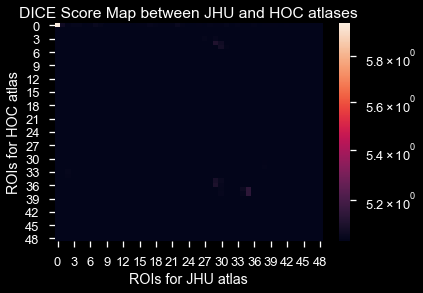

In [78]:
from matplotlib.colors import LogNorm

mypath = '../Nifti_images'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
files
file1 = 'JHU_space-MNI152NLin6_res-1x1x1.nii.gz'
file2 = 'HarvardOxfordcort-maxprob-thr25_space-MNI152NLin6_res-1x1x1.nii.gz'
filename1 = join(mypath, file1)
filename2 = join(mypath, file2)
Dice = Dice_Calculator(filename1,filename2)

Dice = Dice+0.01
sns.heatmap(Dice,
            norm=LogNorm(vmin=Dice.min(), vmax=Dice.max()))
plt.xlabel('ROIs for JHU atlas')
plt.ylabel('ROIs for HOC atlas')
plt.title('DICE Score Map between JHU and HOC atlases')

### Test that the current DICE calculation has expected output when img1=img2

Text(0.5,1,'DICE Score Map between JHU and itself')

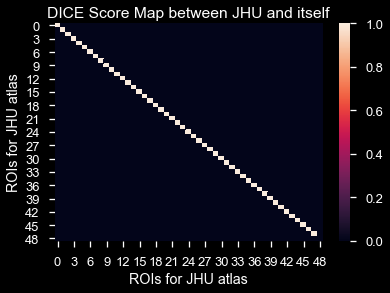

In [84]:
mypath = '../Nifti_images'
file1 = 'JHU_space-MNI152NLin6_res-1x1x1.nii.gz'
file2 = 'JHU_space-MNI152NLin6_res-1x1x1.nii.gz'
filename1 = join(mypath, file1)
filename2 = join(mypath, file2)
Dice = Dice_Calculator(filename1,filename2)
sns.heatmap(Dice)
plt.xlabel('ROIs for JHU atlas')
plt.ylabel('ROIs for JHU atlas')
plt.title('DICE Score Map between JHU and itself')

#### Save output of NMI 
Make sure I do not accidentally overwrite the data

In [2]:
np.save('NMI_scores.npy', NMI_scores)
backup = np.load('NMI_scores.npy')

### Rename files to shorter representation to use as axis tick labels

In [8]:
mypath = '../Nifti_images'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
files = [f for f in files if 'DS' not in f]
files = [f for f in files if 'glasser' not in f]
files = [f for f in files if 'pp264' not in f]
files = [f.split('_')[0] for f in files]
files[5] = 'HOC'
files[6] = 'HOS'
files[9] = 'Princeton'
files[10] = 'Schaefer-1000'
files[11] = 'Schaefer-200'
files[12] = 'Schaefer-300'
files[13] = 'Schaefer-400'
files[14] = 'Schaefer-Yeo17'
files[15] = 'Schaefer-Yeo7'
files

['aal',
 'brodmann',
 'CPAC200',
 'desikan',
 'DKT',
 'HOC',
 'HOS',
 'hemispheric',
 'JHU',
 'Princeton',
 'Schaefer-1000',
 'Schaefer-200',
 'Schaefer-300',
 'Schaefer-400',
 'Schaefer-Yeo17',
 'Schaefer-Yeo7',
 'slab1068',
 'slab907',
 'Talairach',
 'tissue',
 'yeo-17-liberal',
 'yeo-17',
 'yeo-7-liberal',
 'yeo-7']

### Plot heatmap of NMI scores

First, reflect matrix over diagonal since the test is symmetric. Then use seaborn to plot the heatmap with labels as made above

(21, 21)


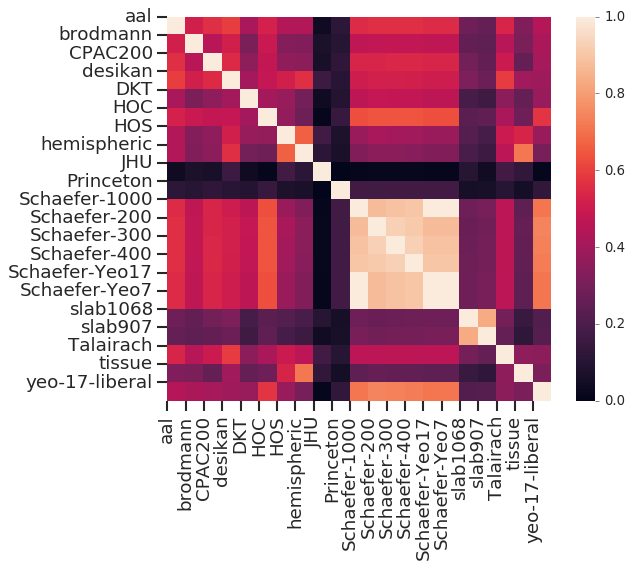

In [9]:
sns.set(style="ticks", context="talk")
fig, ax = plt.subplots()
plt.style.use("classic")


NMI_scores = backup[0:21,0:21]

for i in range(0,21):
    for j in range(i, 21):
        NMI_scores[j][i] = NMI_scores[i][j]
print(NMI_scores.shape)
        
with sns.axes_style("white"):
    ax = sns.heatmap(NMI_scores, square=True)
    
plt.xticks(np.arange(0, 21, 1.0))
plt.yticks(np.arange(0,21,1.0))
    
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = files

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.savefig('../Results/MutualInfoMap')

0
0.9795918367346939
1
0.04365201041766974
2
0.055796297835250724
3
0.06508242507283102
4
0.05845305582282441
1
0.9444444444444444
2
0.6479475084385378
3
0.48415051360934885
4
0.7589853770366274
2
0.9444444444444444
3
0.7590924194568861
4
0.6001510564642418
3
0.875
4
0.6278895217605669
4
0.875


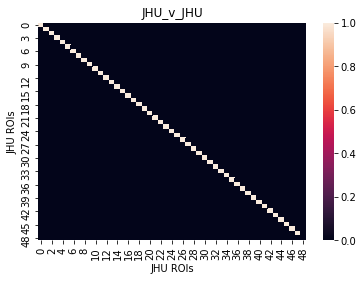

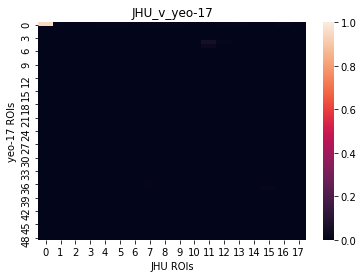

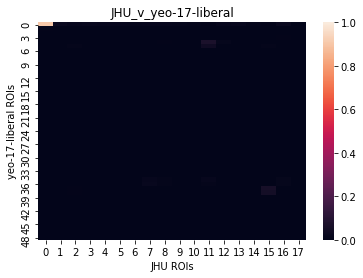

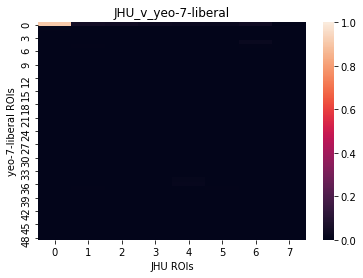

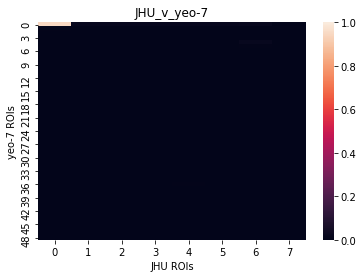

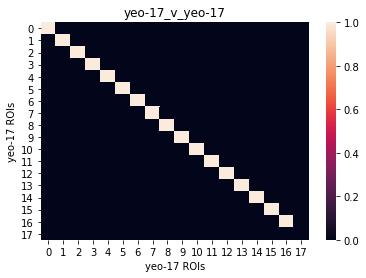

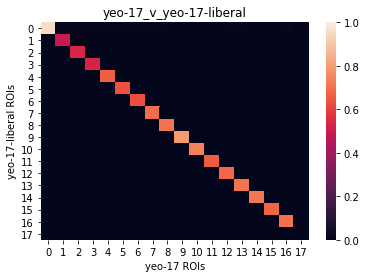

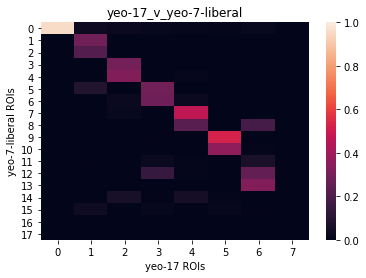

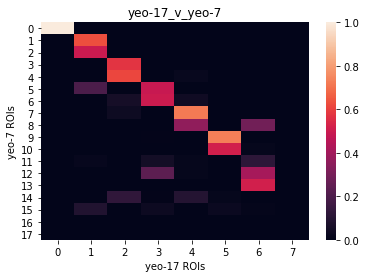

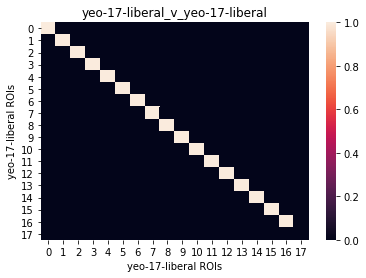

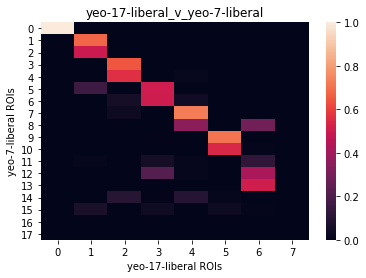

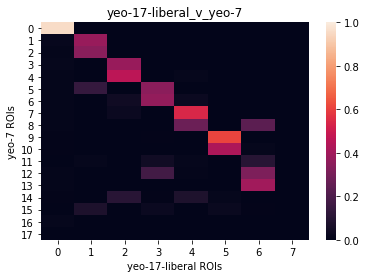

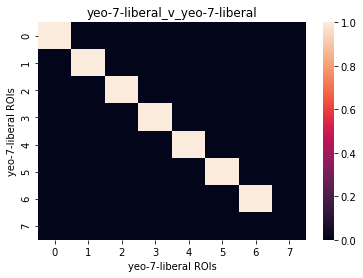

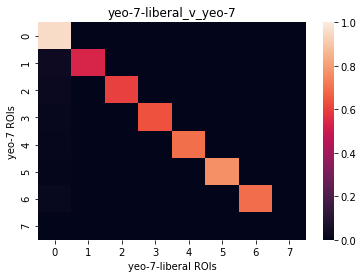

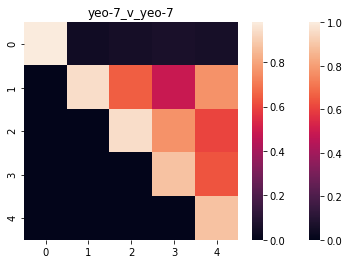

In [35]:
mypath = '../Nifti_images'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
file1 = [f for f in files if 'JHU' in f]
file2 = [f for f in files if 'yeo' in f]
files = file1+file2
#files = file2
#print(files)

Dice_scores = np.zeros((len(files),len(files)),dtype=float)

for i in range(0,len(files)):
    for j in range(i,len(files)):
        print(j)
        image1_name = files[i]
        filename1 = join(mypath, image1_name)
        image2_name = files[j]
        filename2 = join(mypath, image2_name)
        file1 = image1_name.split('_')[0]
        file2 = image2_name.split('_')[0]
        

        Dice, Dice_scores[i][j] = Dice_Calculator(filename1, filename2)
        
            
        fig = plt.subplots()
        ax = sns.heatmap(Dice, vmin=0, vmax=1)
        ax.set_title(file1 + '_v_' + file2)
        ax.set_xlabel(file1+' ROIs')
        ax.set_ylabel(file2+' ROIs')
        plt.savefig('../Results/' + file1+'_v_'+file2+'.png')

sns.heatmap(Dice_scores)
    

In [37]:
backup2 = Dice_scores

(5, 5)


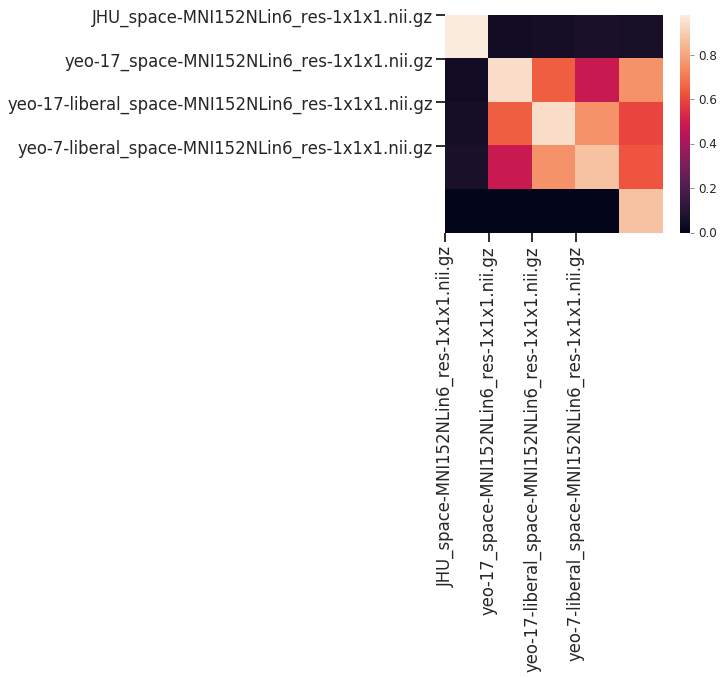

In [38]:
sns.set(style="ticks", context="talk")
fig, ax = plt.subplots()
plt.style.use("classic")



for i in range(0,5):
    for j in range(i, 4):
        Dice_scores[j][i] = Dice_scores[i][j]
print(Dice_scores.shape)
        
with sns.axes_style("white"):
    ax = sns.heatmap(Dice_scores, square=True)
    
plt.xticks(np.arange(0, 4, 1.0))
plt.yticks(np.arange(0, 4,1.0))
    
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = files

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.savefig('../Results/DiceMap')